In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

In [4]:
style.use('ggplot')

In [5]:
conn = MongoClient()
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

In [6]:
df.replace('', np.nan, inplace=True)

In [7]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum().sum()

0

In [8]:
df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

In [ ]:
df['moving_distance'] = np.abs(df.latitude.diff() * 111000) + np.abs(df.longitude.diff() * 110987)

In [12]:
X = np.array(list(zip(df.hr_value, df.step_value)))

In [15]:
# Number of clusters
k = 2
# X coordinates of random centroids
C_x = np.random.randint(0, np.max(X)-30, size=k)
# Y coordinates of random centroids
C_y = np.random.randint(0, np.max(X)-30,size=k)
C = np.array(list(zip(C_x, C_y)), dtype=np.float32)
# C_x = [-2, 6]
# C_y = [4, -6]
# C = np.array(list(zip(C_x,C_y)))
print(C)

[[ 53. 154.]
 [200. 119.]]


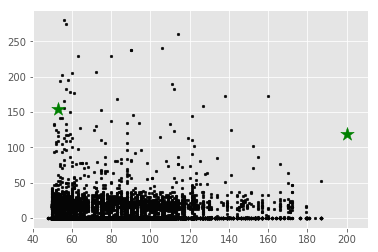

In [16]:
# Plotting along with the Centroids
fig = plt.figure()
plt.scatter(df.hr_value, df.step_value, c='#050505', s=7)
plt.scatter(C_x, C_y, marker='*', s=200, c='g')
plt.show()

In [17]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [18]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
# Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster    
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = deepcopy(C)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)
    clear_output(wait=True)
    print(error)

0.0


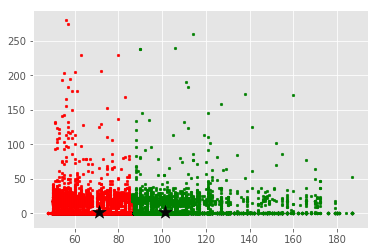

In [19]:
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')
plt.show()

In [20]:
df['cluster'] = clusters
df['clusterDiff'] = df.cluster.diff()

In [23]:
dftspdiff = df['timestamp'].diff()
dftfdiffSTD = dftspdiff.rolling(20).std()

# find the place that std is smaller than 5
lis = []
changeFlag = 0
tempt = [0]
for i in range(len(dftfdiffSTD)):
    if dftfdiffSTD[i] < 5 and changeFlag == True and len(tempt) < 2:
        tempt.append(i)
        changeFlag = False
    if dftfdiffSTD[i] >= 5 and changeFlag == False and len(tempt) < 2:
        tempt.append(i-1)
        changeFlag = True
    if len(tempt) == 2:
        lis.append(tempt)
        tempt = []
# print(lis)

In [25]:
data_with_gap = []
for i in lis:
    data_with_gap.append(df[i[0]:i[1]])

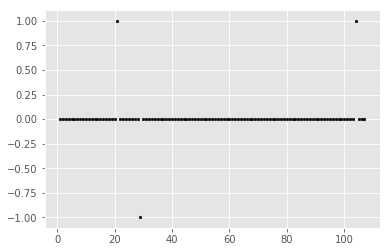

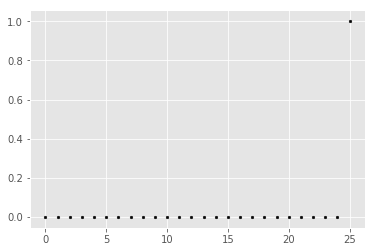

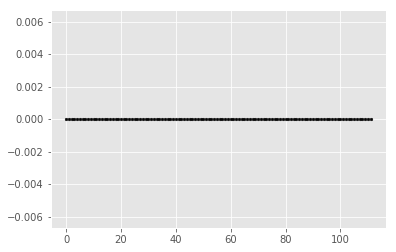

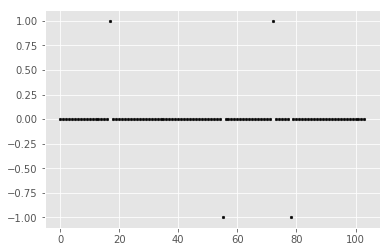

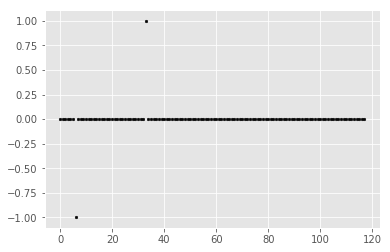

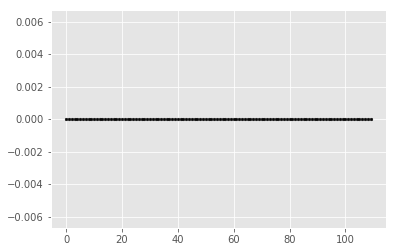

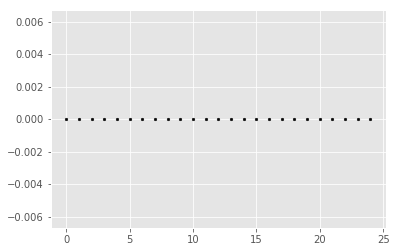

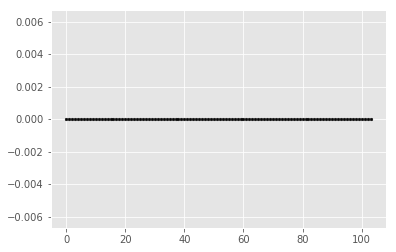

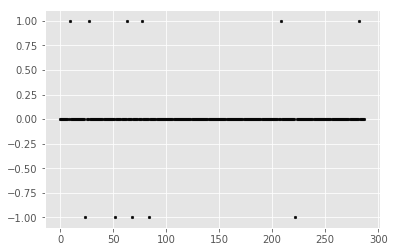

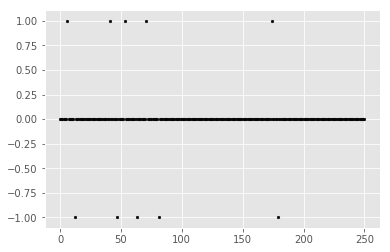

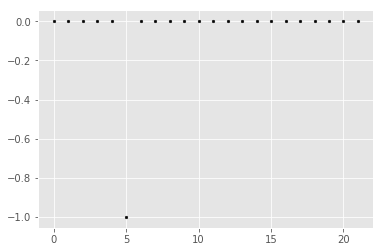

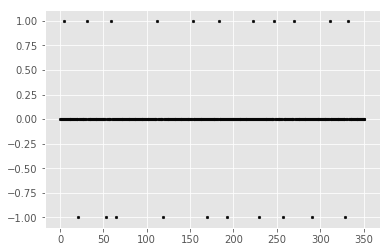

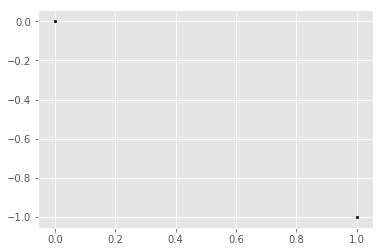

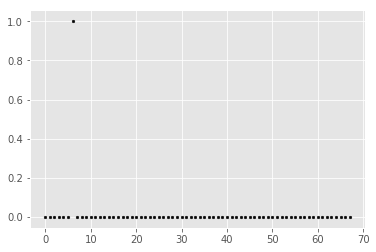

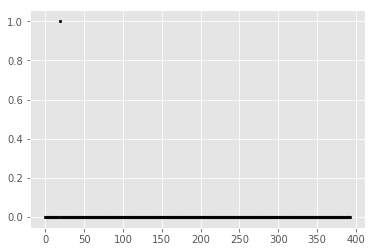

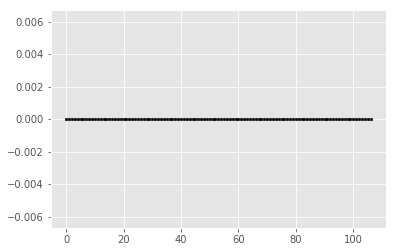

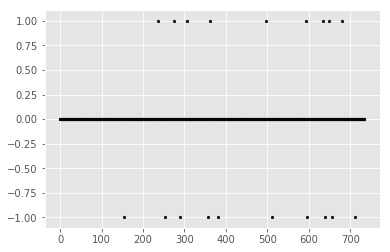

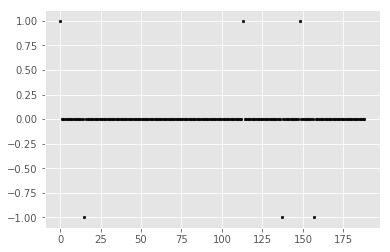

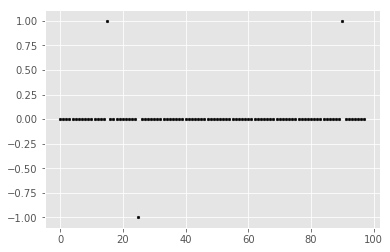

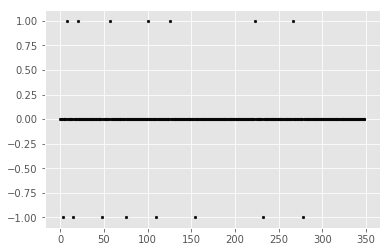

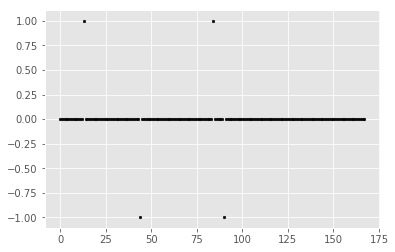

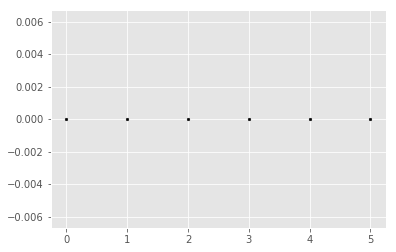

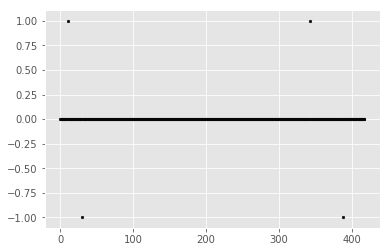

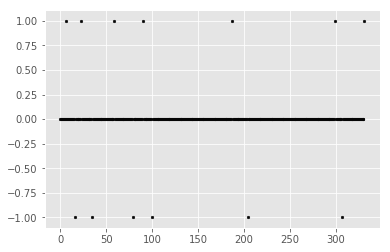

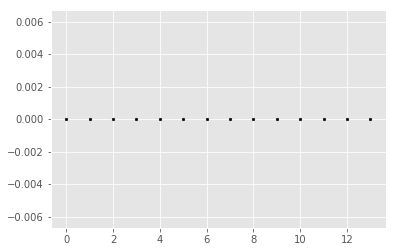

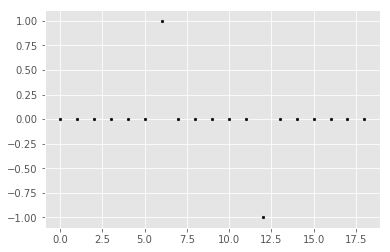

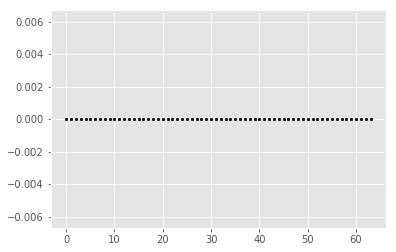

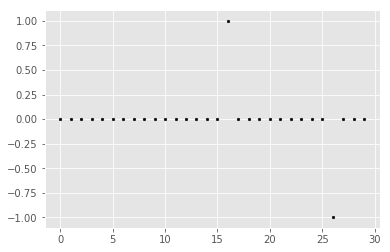

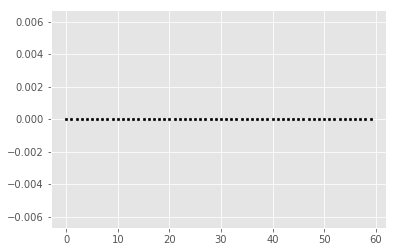

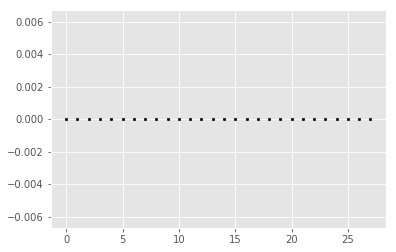

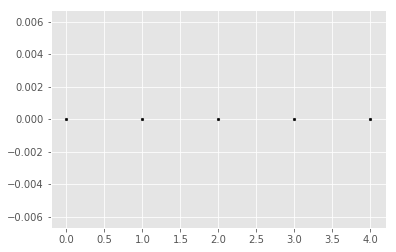

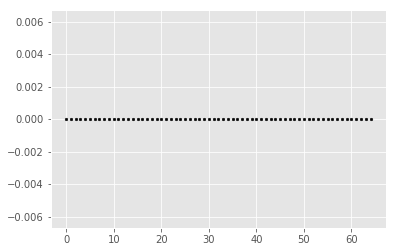

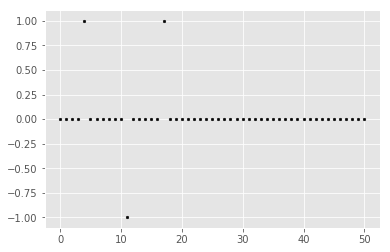

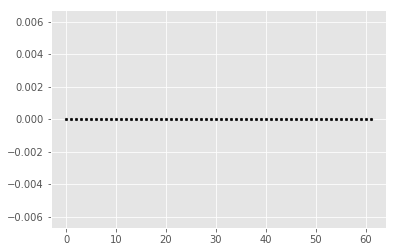

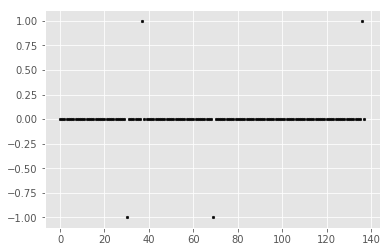

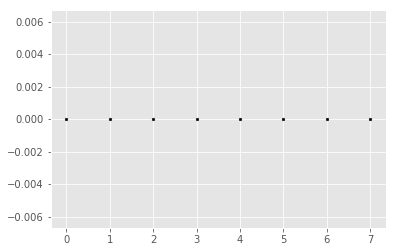

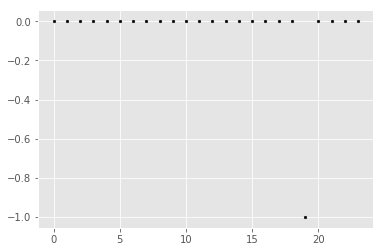

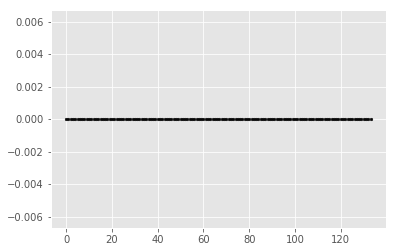

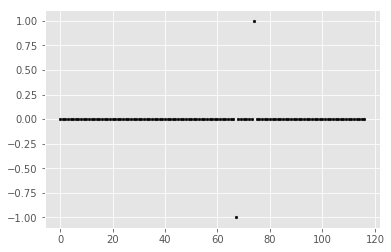

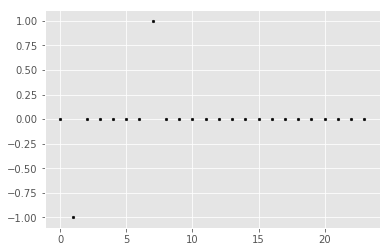

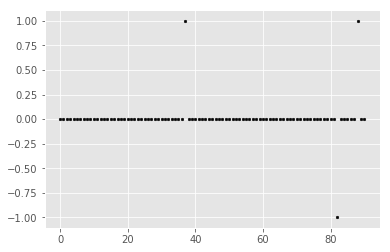

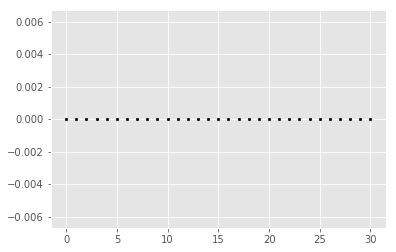

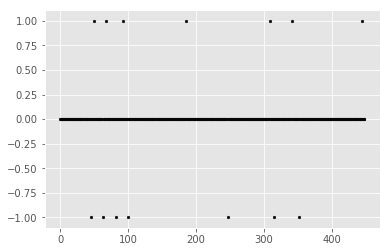

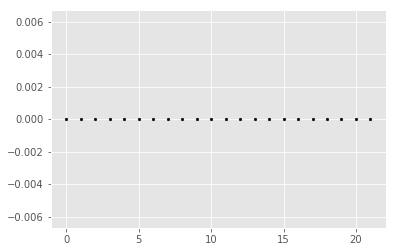

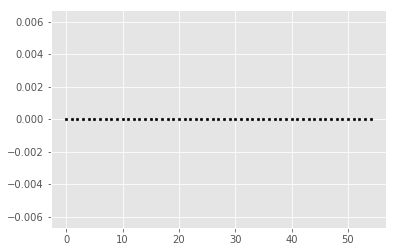

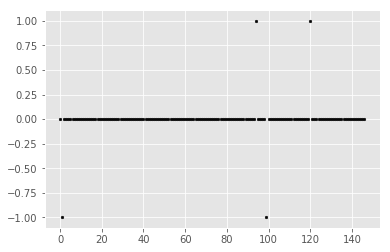

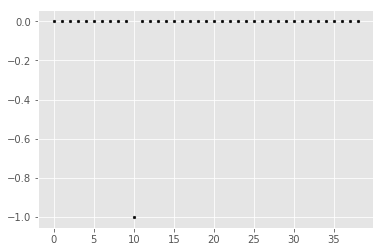

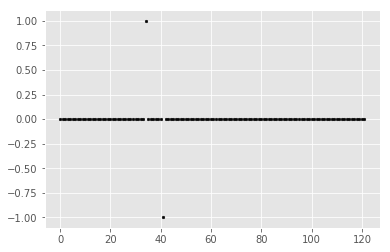

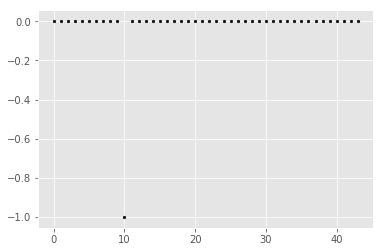

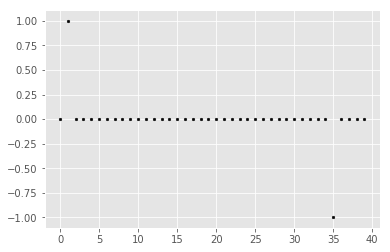

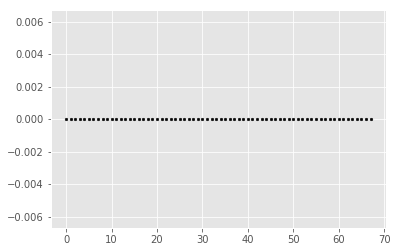

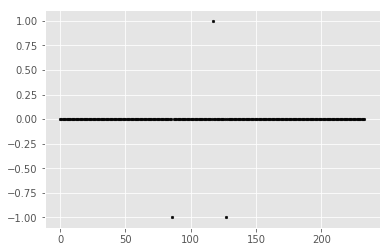

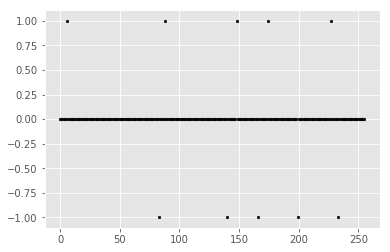

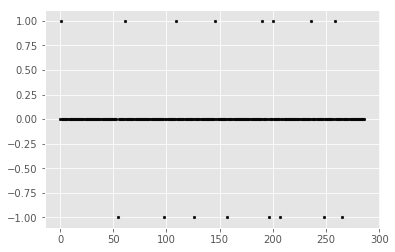

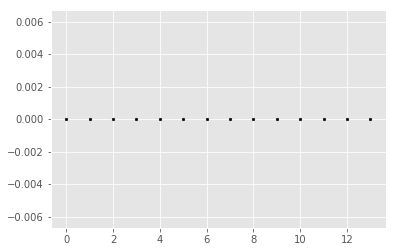

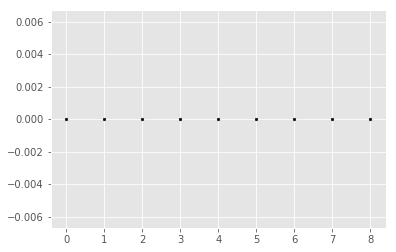

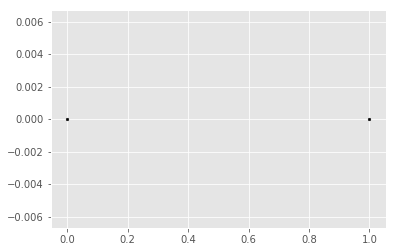

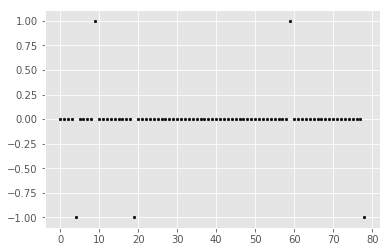

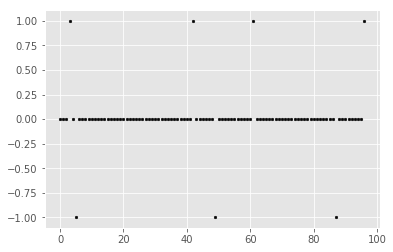

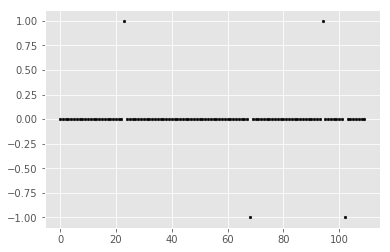

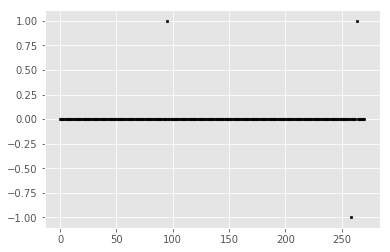

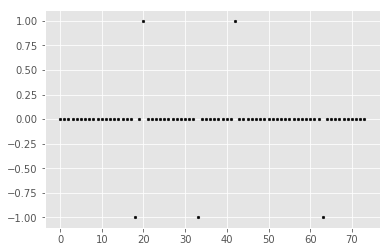

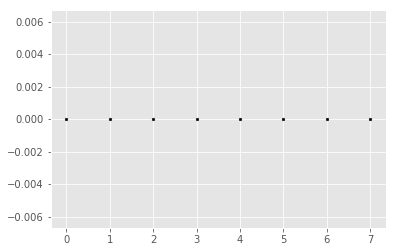

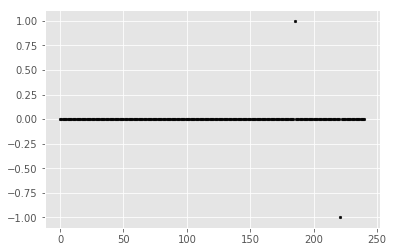

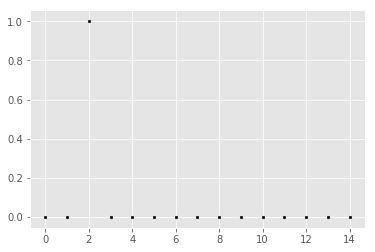

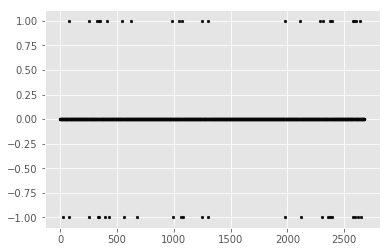

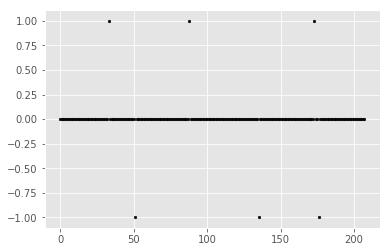

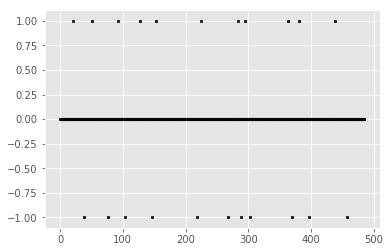

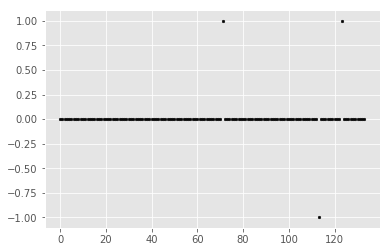

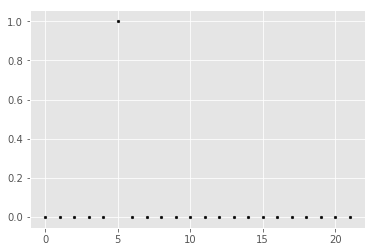

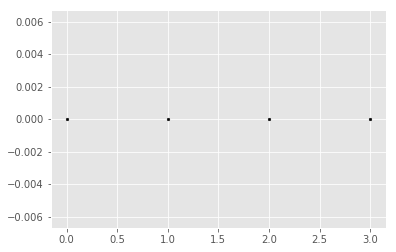

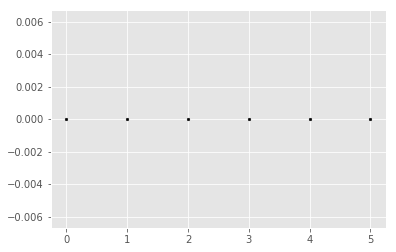

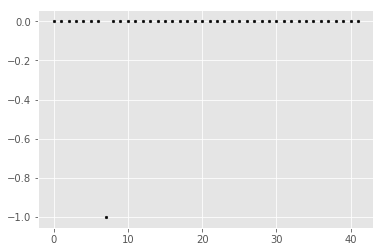

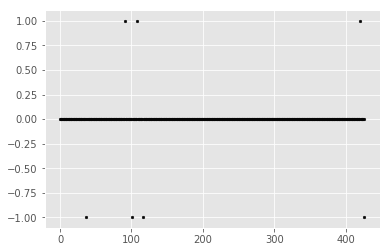

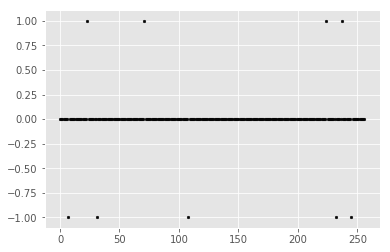

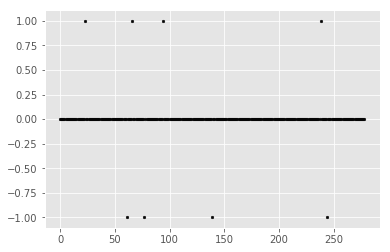

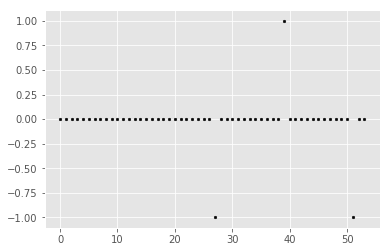

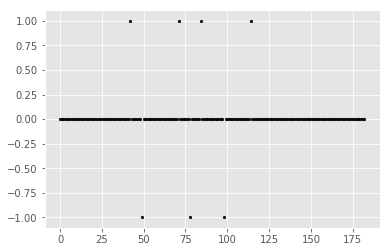

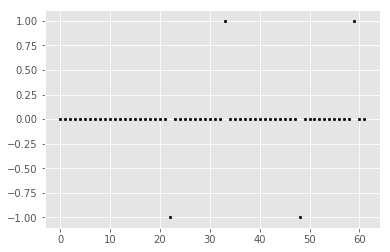

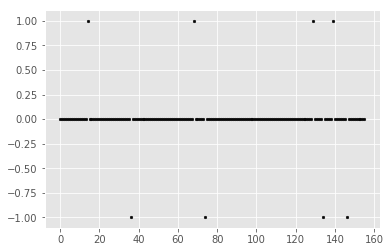

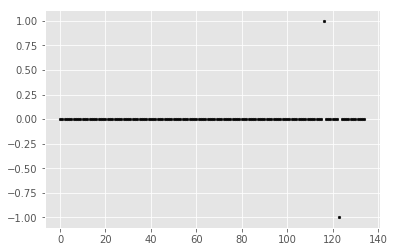

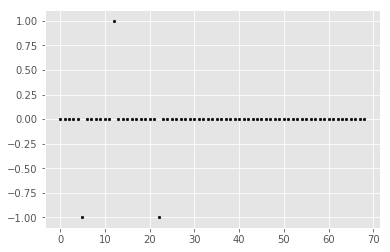

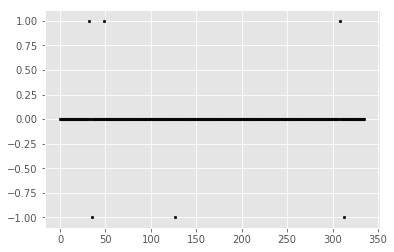

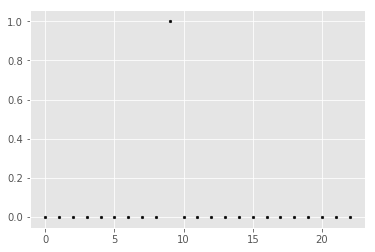

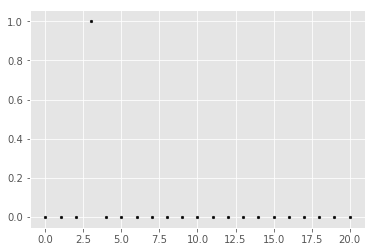

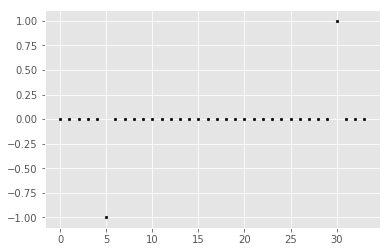

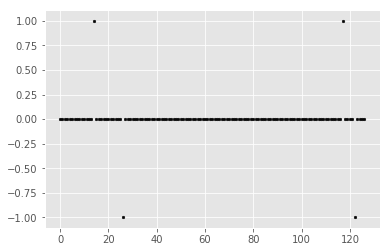

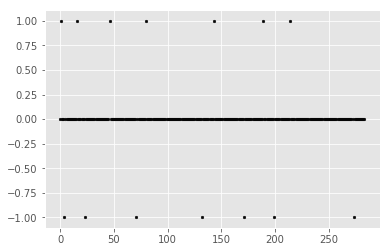

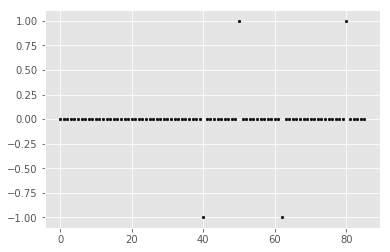

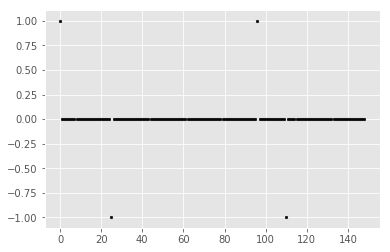

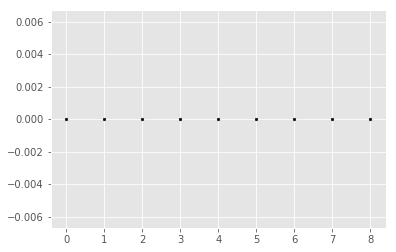

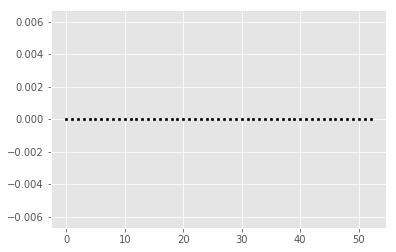

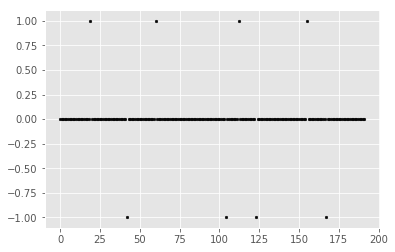

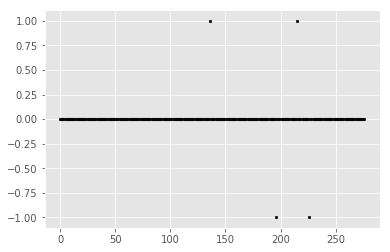

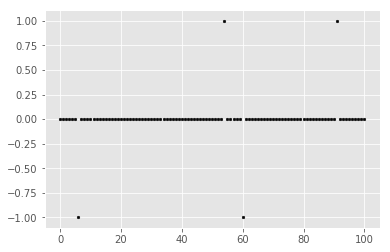

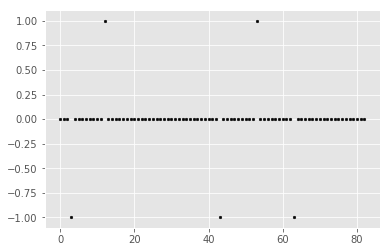

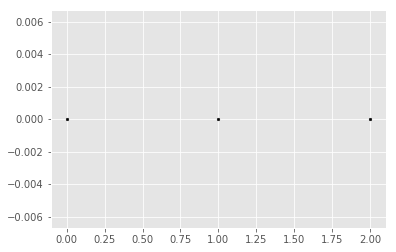

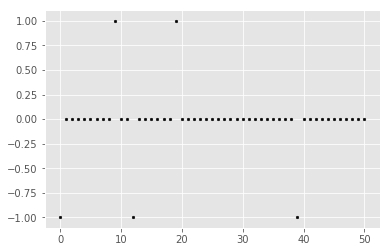

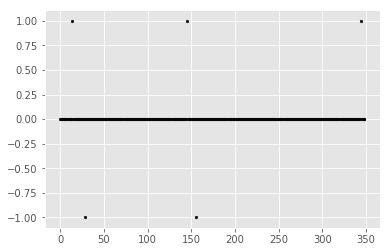

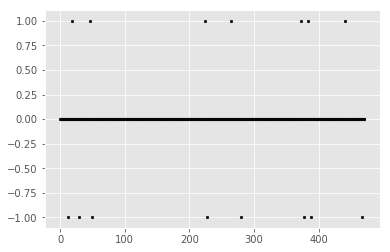

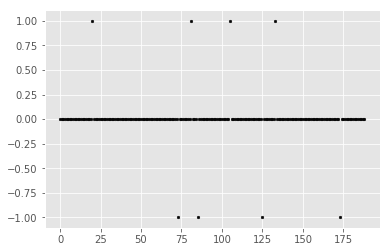

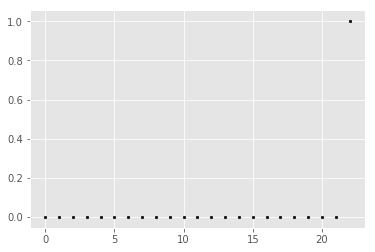

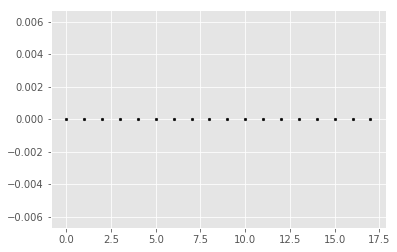

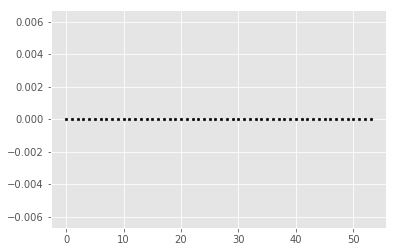

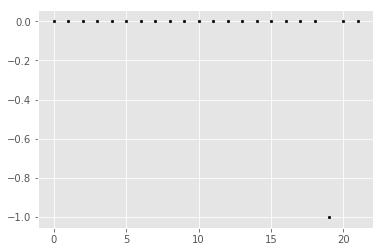

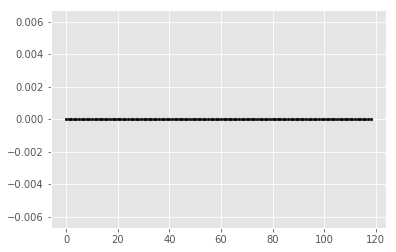

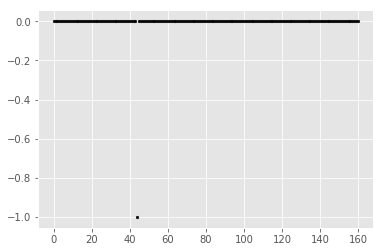

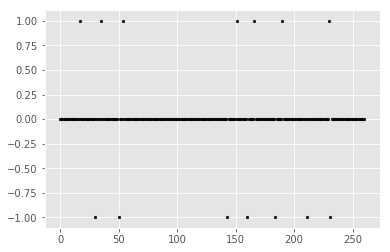

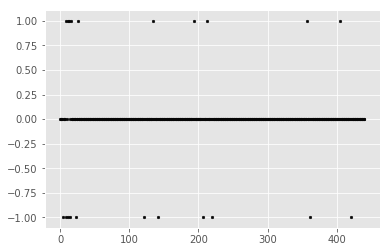

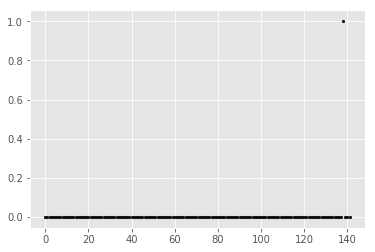

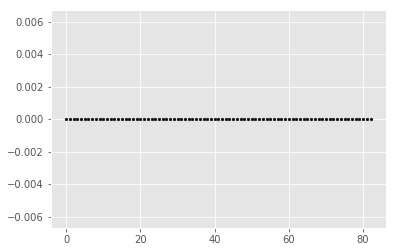

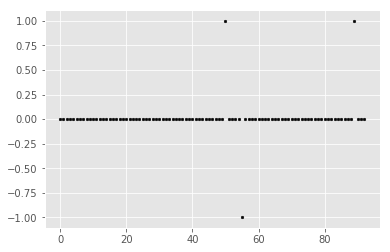

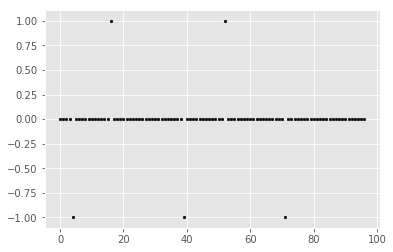

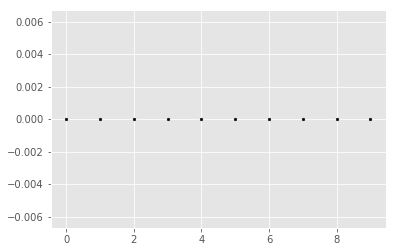

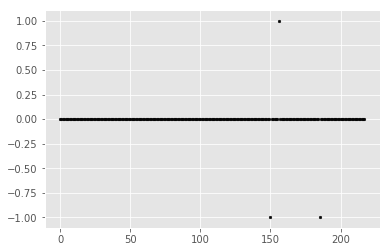

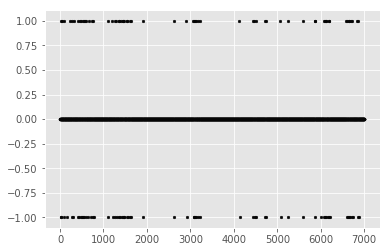

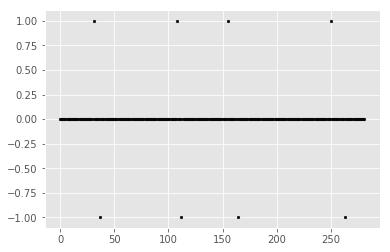

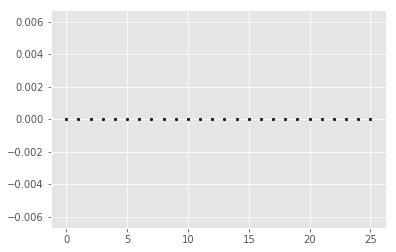

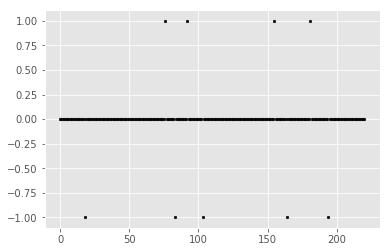

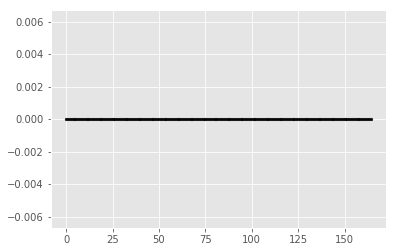

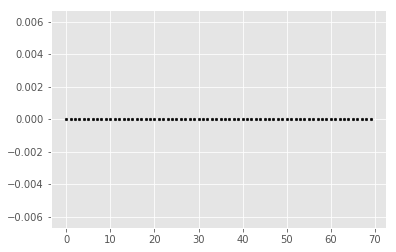

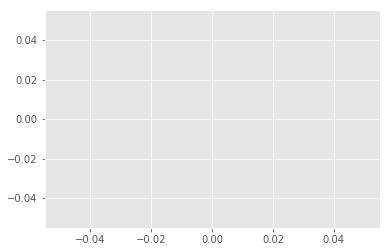

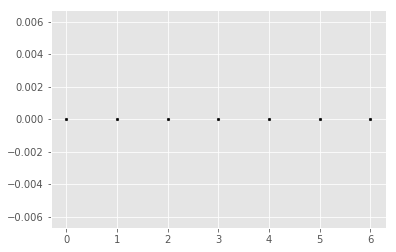

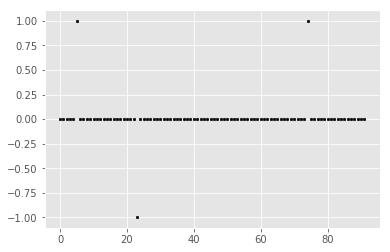

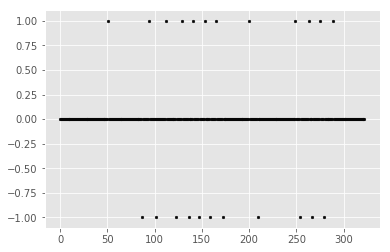

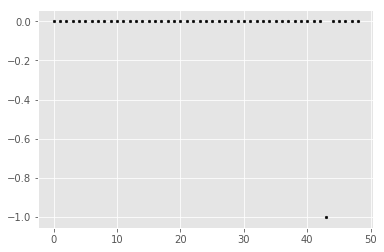

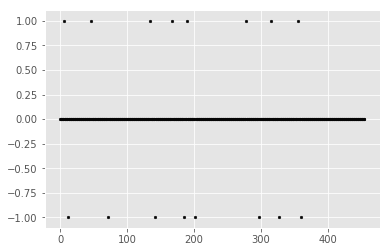

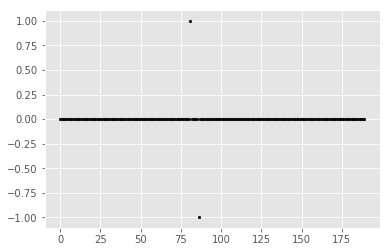

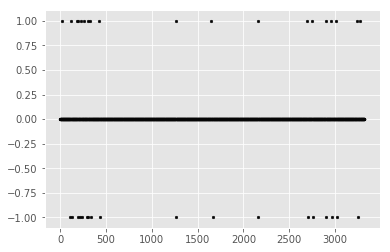

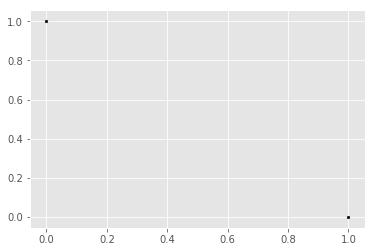

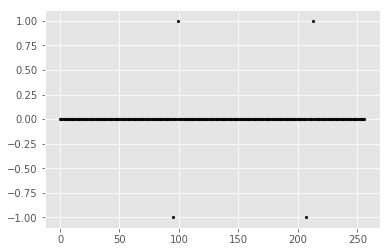

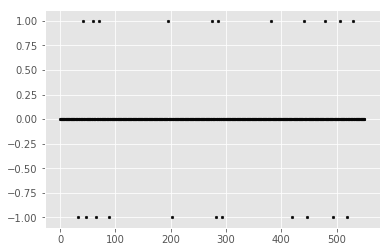

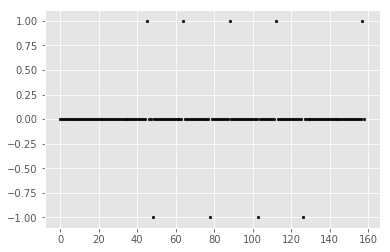

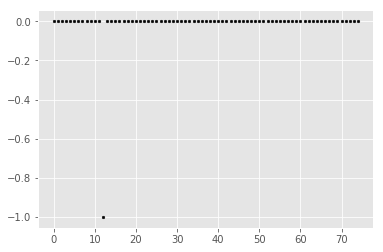

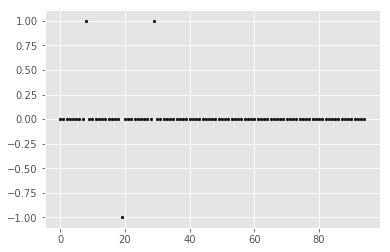

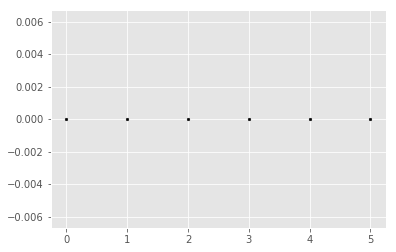

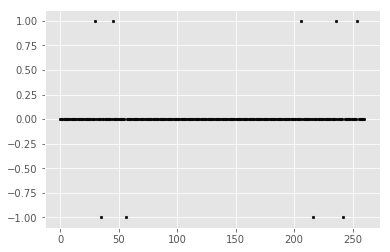

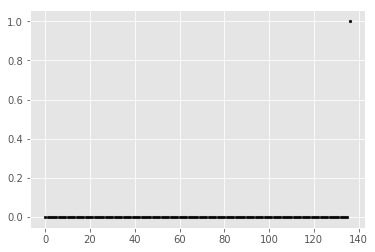

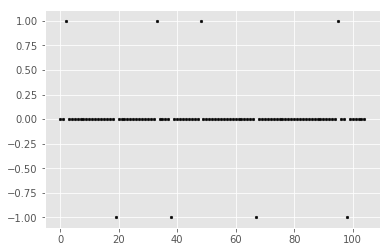

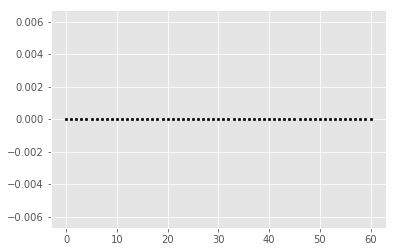

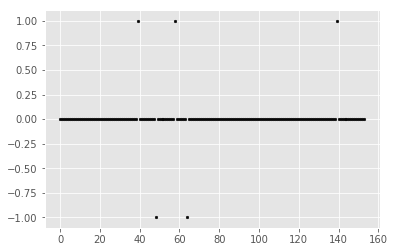

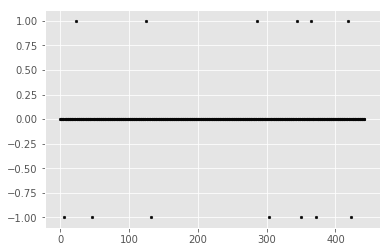

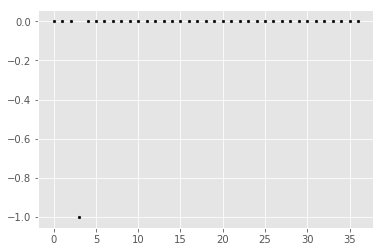

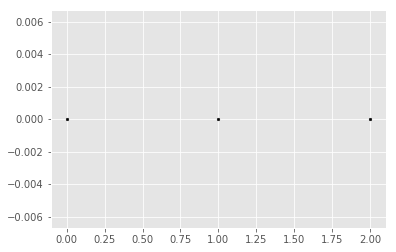

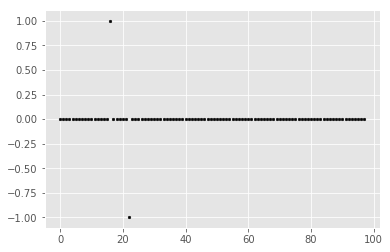

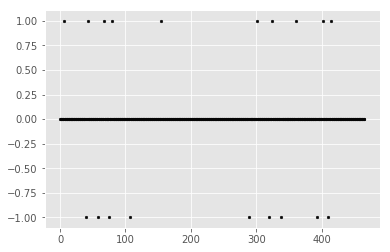

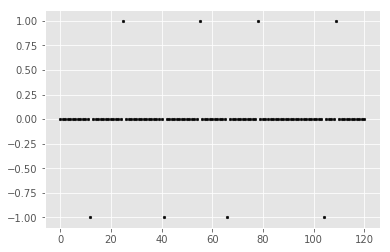

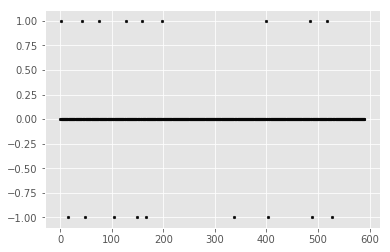

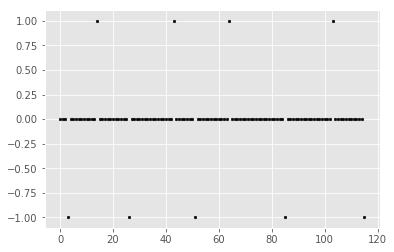

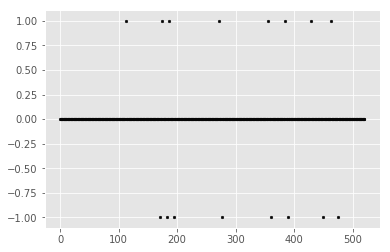

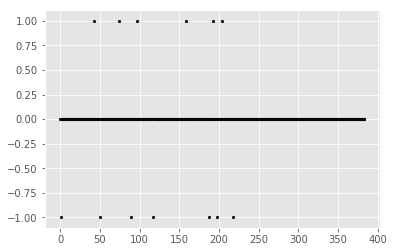

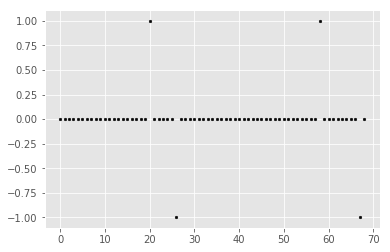

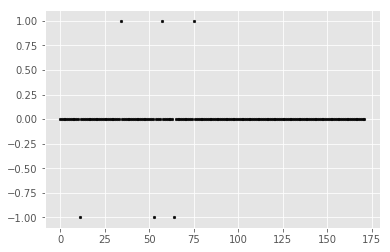

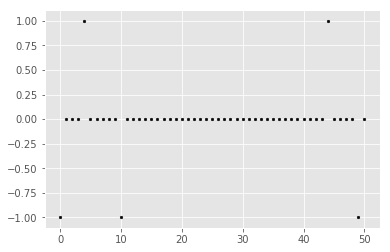

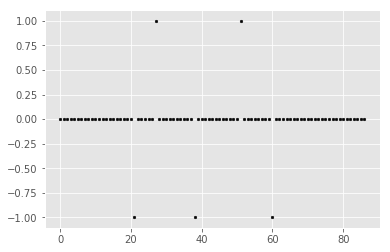

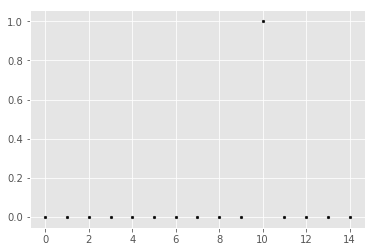

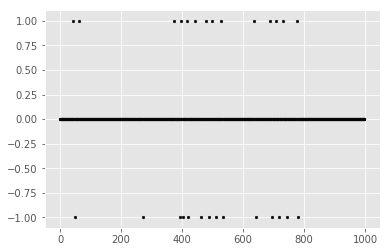

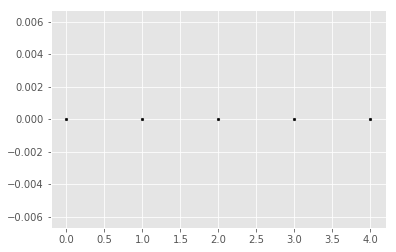

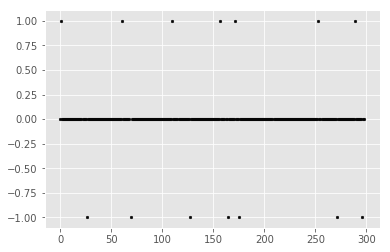

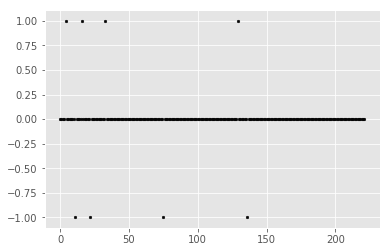

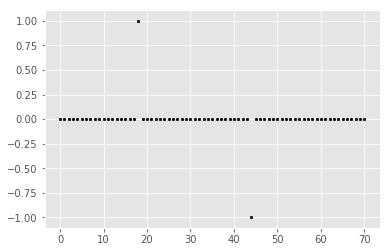

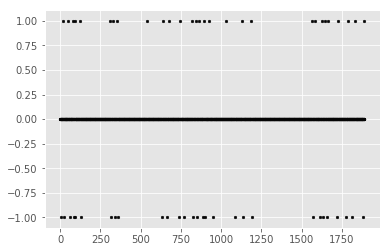

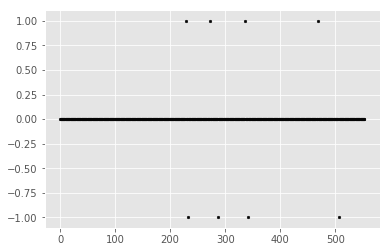

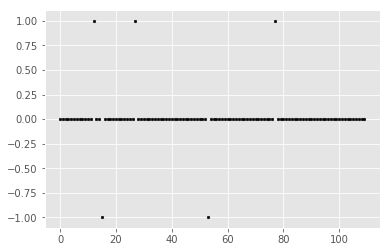

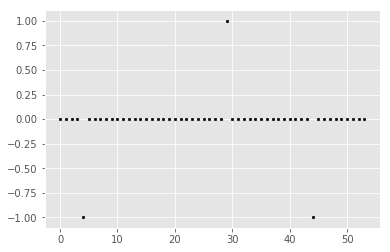

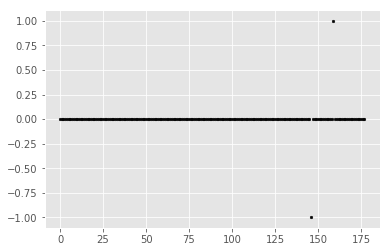

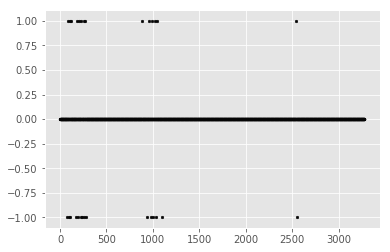

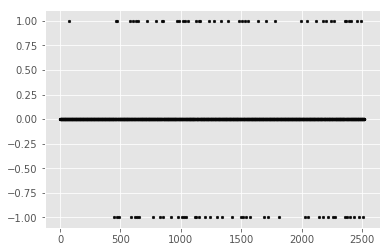

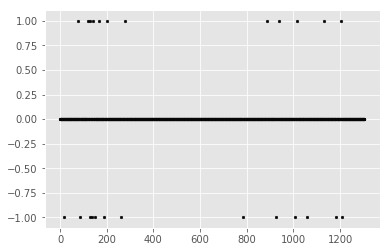

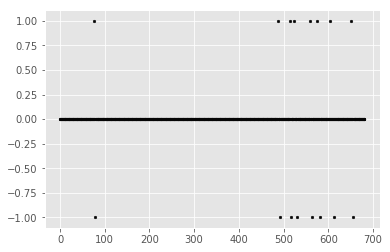

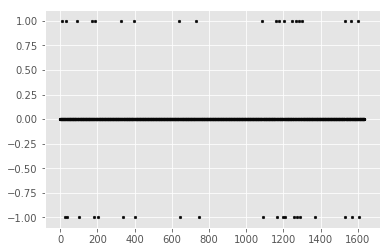

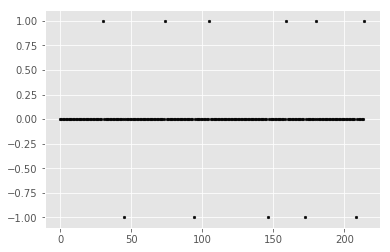

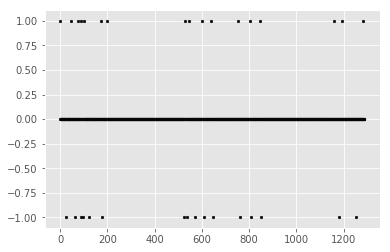

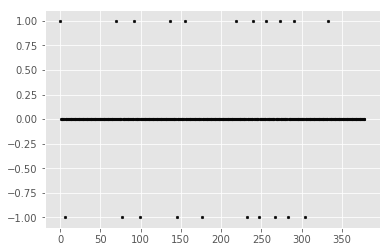

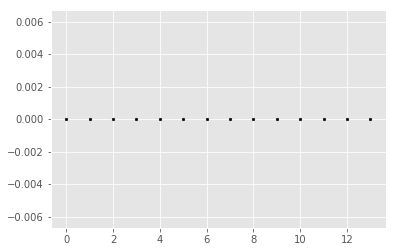

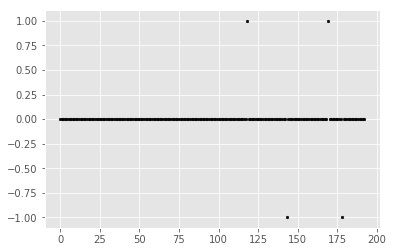

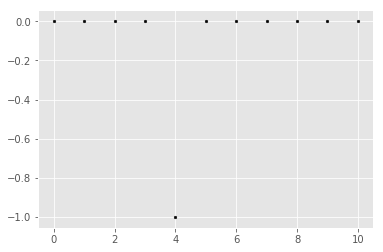

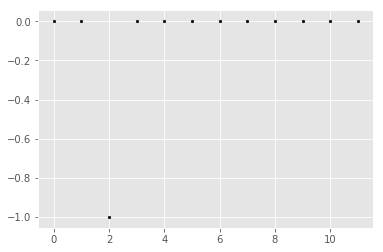

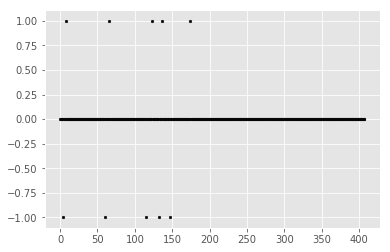

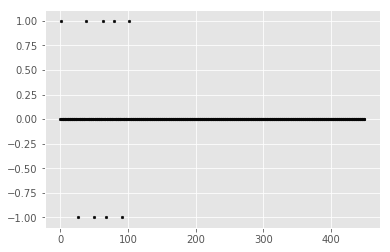

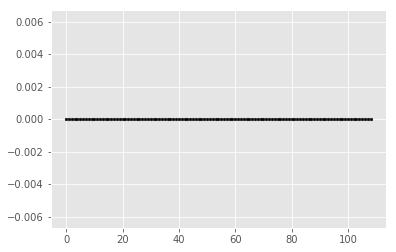

In [35]:
%matplotlib inline

for i in range(len(data_with_gap)):
    fig = plt.figure()
    plt.scatter(range(len(data_with_gap[i]['clusterDiff'])),data_with_gap[i]['clusterDiff'], c='#050505', s=7)
    plt.show()